# 26 - Classifying All-NBA Players (Part VIII - Neural Networks)
Alright, we're running out of classifiers for us to try here. We've already gotten some pretty decent results thus far. My personal favorite has probably been just a single decision tree or the random forest. The interpretability of those models are pretty cool. LDA and QDA are also pretty neat because of their simplicity, but the accuracy of the trees has literally been the best so far.

I'm going to move on to Neural Networks in this post. I know for a fact that NN is overkill here because of
1. How simple this application is
2. How uninterpretable an NN is (I don't even think you can map a decision boundary...)

but there's so much buzz around NNs... how can I resist!

At the end of the day, an NN is basically just a linear sum of sigmoid functions... I think that's literally it! Through all the mess of the nodes, optimizing actually becomes quite easy because of the chain rule in calculus and leveraging gradient descent. Love it how something seemingly so complicated just ends up being so simple. So simple we can't even interpret the results... har har har...............

Anyways, this video was a lifesaver for understanding NN's (as well as ESL):

[![IMAGE ALT TEXT](http://img.youtube.com/vi/bH6VnezBZfI/0.jpg)](http://www.youtube.com/watch?v=bH6VnezBZfI "Video Title")

It is really able to visually break down how an NN is constructed. To give a super quick rundown on an NN, we'll start off with what one even looks like:

<img src="https://qph.ec.quoracdn.net/main-qimg-0b301ad05fd25916b36804a697fe6cea" style="width: 400px;"/>

Yeah... pretty bad joke eh? I was on the fence. I think I'm getting way too deep into the modelling right now and I'm just barely trying on the jokes anymore. Oh well, I guess it's probably better this way than vice versa.

Sorry, here's a real neural network... the STATISTICAL MODEL:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/neuralnet/1neuralnetexample.png" style="width: 500px;"/>

The above was taken from ESL and shows your 'vanilla' single layer neural network. In the case of regression, we have a single output node and that output node will be the value of the regressed output. In the case of classification, we have the same number of output nodes as we have classes, and each node will output the probability of the result being that class.

The number of input nodes will always match the number of features we have. The number of hidden layer nodes (and hidden layers themselves) will govern the complexity of the neural network. The more hidden layer nodes, the more complex a neural network can become and the more flexibility it has to map abstract functions.

If the last paragraph didn't make sense, it likely will by the end of this introduction.

Again, a neural network is simply viewed as a linear combination of sigmoid functions. Each node basically has a sigmoid function and a weight tied to it:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/neuralnet/2sigmoid.png" style="width: 400px;"/>

The sigmoid function is basically a smoothed out step function. Let's forget the sigmoid for now and just look at a simple step function. We can imagine a situation where a simple step function is all we need to perform a regression or classification... see below:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/neuralnet/3simplefunc.png" style="width: 200px;"/>

This function is nice. It's simple, it gets most of the job done, but it doesnt get the entire job done. We've misclassified one blue point and one red point. If we bend our step function a bit, we can get the following model:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/neuralnet/4complexfunc.png" style="width: 200px;"/>

Here, we're getting all the points. Does it overfit? That really depends on test data, but for the purposes of the training data, we're happy we've even found a _**function at all**_ that can get 100% accuracy on the training data. How do we make this function??

Well, we can do so by actually simply combining multiple step functions! If they are shifted and weighted with a magnitude, we can use an infinite amount (or a large amount) to build whatever model we want!

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/neuralnet/5linearsumfuncs.png" style="width: 400px;"/>

We can see that this is basically what the neural net is doing. It's trying to find some possible way of building the optimal function based on the shifts and weights of its nodes:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/neuralnet/6neuralnetworkstep.png" style="width: 500px;"/>

How do we perform this optimization? We essentially take a look at the last output and simply take the derivative to see if we can gradient descent to a local optimum (yeah, we could get stuck in local optimas here...). This may seem like a pretty crazy derivative to take... we have so many factors that affect our output and we basically have to take the partial derivates of our final output with respect to all these parameters, but the chain rule actually allows these calculations to be somewhat scalable, at least to the point that the calculations scale linearly and a computer is able to handle it. More information can be found in the video as I won't go into the heavy math here.

If we abstract this step function idea to use the sigmoid function with another parameter to adjust the "smoothness" of the sigmoid function, we've just unlocked a ridiculous amount of freedom to model... well... basically _**any**_ function!

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/neuralnet/7neuralnetworksigmoid.png" style="width: 500px;"/>

Let's try one out!

In [1]:
# Load libraries & initial config
%load_ext rpy2.ipython

%R library(ggplot2)
%R library(gridExtra)
%R library(scales)
%R library(ggbiplot)
%R library(dplyr)

%matplotlib nbagg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from StringIO import StringIO
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Retrieve team stats from S3
playerAggDfAllNbaAllStar = pd.read_csv('https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/data/playerAggDfAllNbaAllStar.csv', index_col = 0)

pd.set_option('display.max_rows', len(playerAggDfAllNbaAllStar.dtypes))
print playerAggDfAllNbaAllStar.dtypes
pd.reset_option('display.max_rows')

season_start_year          int64
perGameStats_Player       object
perGameStats_Pos          object
perGameStats_Age           int64
perGameStats_Tm           object
perGameStats_G             int64
perGameStats_GS          float64
perGameStats_MP          float64
per100Stats_FG           float64
per100Stats_FGA          float64
per100Stats_FGPerc       float64
per100Stats_3P           float64
per100Stats_3PA          float64
per100Stats_3PPerc       float64
per100Stats_2P           float64
per100Stats_2PA          float64
per100Stats_2PPerc       float64
per100Stats_FT           float64
per100Stats_FTA          float64
per100Stats_FTPerc       float64
per100Stats_ORB          float64
per100Stats_DRB          float64
per100Stats_TRB          float64
per100Stats_AST          float64
per100Stats_STL          float64
per100Stats_BLK          float64
per100Stats_TOV          float64
per100Stats_PF           float64
per100Stats_PTS          float64
per100Stats_ORtg         float64
per100Stat

First, we actually scale our inputs. The reasoning for this is apparently not much to do with the functionality of the model itself (as nodes can be reweighted accordingly to the scale that the inputs are on), but it actually helps make the process more efficient and apparently helps avoid getting stuck in a local optima.

In [3]:
%%R -i playerAggDfAllNbaAllStar

# Scale inputs
playerAggDfAllNbaAllStar['advancedStats_WS_scaled'] = scale(playerAggDfAllNbaAllStar['advancedStats_WS'])
playerAggDfAllNbaAllStar['advancedStats_VORP_scaled'] = scale(playerAggDfAllNbaAllStar['advancedStats_VORP'])
playerAggDfAllNbaAllStar['accolades_all_nba_coded'] = ifelse(playerAggDfAllNbaAllStar['accolades_all_nba'] == 'All-NBA', 1, 0)

In [5]:
%%R

library(neuralnet)

# Build neural net
nnModel = neuralnet(
    accolades_all_nba_coded ~ advancedStats_WS_scaled + advancedStats_VORP_scaled,
    data = playerAggDfAllNbaAllStar,
    hidden = 2,
    err.fct = 'ce',
    lifesign = 'full',
    linear.output = FALSE
)

That neural net took... _**5 minutes**_ to train!!! I thought I was being cute with just one hidden layer with two nodes, but apparently that still takes 5 minutes. In the console, I could see the output from the 'lifesign' parameter, which simply gives us a verbose update. The output did say the neural net was working towards a 0.01 error thersholdon the partial derivatives... I'll have to review what exactly this threshold is but that's definitely a place to start if I ever wanted to lower the training time!

Let's take a look at the ROC curve from this model.

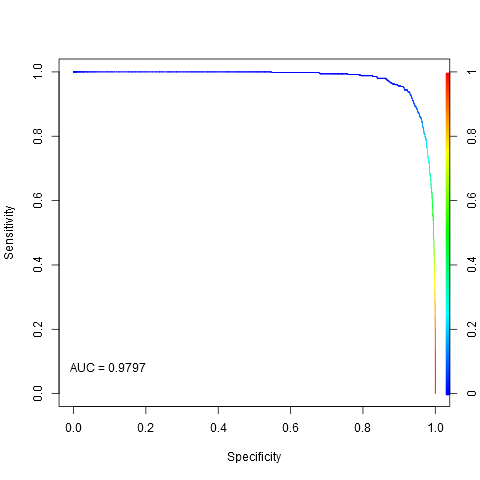

In [43]:
%%R

library(neuralnet)

# Use the tree library to predict probabilities
nnModelPred = compute(nnModel, playerAggDfAllNbaAllStar[,c('advancedStats_WS_scaled', 'advancedStats_VORP_scaled')])

# There are "prediction" functions in both the neuralnet and ROCR package, we can't have both loaded in at the same time
detach(package:neuralnet,unload = T)
library(ROCR)

# Use the ROCR library to build the ROC curve
nnModelPredObj = prediction(nnModelPred$net.result, ifelse(playerAggDfAllNbaAllStar['accolades_all_nba'] == 'All-NBA', TRUE, FALSE))

# Run performance evaluation for the metric 'total accuracy'
nnModelRocEval = performance(nnModelPredObj, 'sens', 'spec')
plot(nnModelRocEval, colorize = T)
text(
    0.2, 
    0.08, 
    labels = paste("AUC = ", round(performance(nnModelPredObj, 'auc')@y.values[[1]], digits = 4), sep= ""), 
    adj = 1
)

Wow, there we go, I don't know if we really need anything more here! I'm getting the same AUC as the decision tree I built before, and let's take a look at the best sens / spec metrics:

In [44]:
# Retrieve the iterative cut-off sensitivity analysis that logistic regression did behind the scenes
%R cutoffs = data.frame(cut = nnModelRocEval@alpha.values[[1]], sens = nnModelRocEval@x.values[[1]], spec = nnModelRocEval@y.values[[1]])

# Calculate the metrics sensitivity + specificity. This will help us gauge the accuracy of both classes simultaneously.
#   E.g. if we were guessing each class 100% correctly (there is a very distinct decision boundary), then we would have 1 + 1 = 2
%R cutoffs['sens_plus_spec'] = cutoffs['sens'] + cutoffs['spec']

# See the last few rows of this dataframe where the sensitivity + specificity are at its max
%R tail(cutoffs[order(cutoffs$sens_plus_spec),])

,cut,sens,spec,sens_plus_spec
1037,0.044727,0.921764,0.944223,1.865988
1036,0.044851,0.921922,0.944223,1.866145
1035,0.044892,0.922000,0.944223,1.866223
1034,0.045058,0.922236,0.944223,1.866459
1033,0.045303,0.922393,0.944223,1.866617
1032,0.045469,0.922472,0.944223,1.866695


94% / 92%... Not bad at all!

One characteristic of neural nets is that we essentially start with random weights. The randomization of weights may cause us to live in a local maxima, or depending on how we stop our neural network (maximum # of iterations? error threshold?), we can actually end up with different results per neural network.

The neuralnet library has a rep function which allows us to train multiple nets with random starting weights to see if any of them do better than the others.

In [6]:
%%R

library(neuralnet)

# Build neural net, repeating 5 times, storing 5 models
nnModelRep5 = neuralnet(
    accolades_all_nba_coded ~ advancedStats_WS_scaled + advancedStats_VORP_scaled,
    data = playerAggDfAllNbaAllStar,
    hidden = 2,
    threshold = 0.05,
    err.fct = 'ce',
    lifesign = 'full',
    lifesign.step = 5000,
    linear.output = FALSE,
    rep = 5
)

Grr, getting R to output in python via rpy2 is pretty annoying... For now, I'm just going to post the output of the neural network model above:

hidden: 2    thresh: 0.05    rep: 1/5    steps:    5000 min thresh: 0.2075644215
- 10000 min thresh: 0.06847760868
- 13958 error: 791.3198

time: 58.47 secs

hidden: 2    thresh: 0.05    rep: 2/5    steps:    5000 min thresh: 0.3481586632
- 10000 min thresh: 0.07653071371
- 15000 min thresh: 0.05960859873
- 15895 error: 791.35664

time: 1.08 mins

hidden: 2    thresh: 0.05    rep: 3/5    steps:    5000 min thresh: 0.3468716589
- 10000 min thresh: 0.1031144785
- 12088 error: 791.40614

time: 49.1 secs

hidden: 2    thresh: 0.05    rep: 4/5    steps:    5000 min thresh: 0.3831256971
- 10000 min thresh: 0.255341992
- 15000 min thresh: 0.128692032
- 20000 min thresh: 0.07226071298
- 25000 min thresh: 0.05648458323
- 30000 min thresh: 0.05648458323
- 34545 error: 791.49393

time: 2.41 mins

hidden: 2    thresh: 0.05    rep: 5/5    steps:    5000 min thresh: 0.3445472464
- 10000 min thresh: 0.2133537315
- 15000 min thresh: 0.08043855153
- 17972 error: 791.36269
time: 1.3 mins

All the errors are more or less the same, and in fact it's quite close to what it was even for the 0.01 threshold as well! In this case, I don't think it really matters which model I take necessarily... Let's just take the first model.

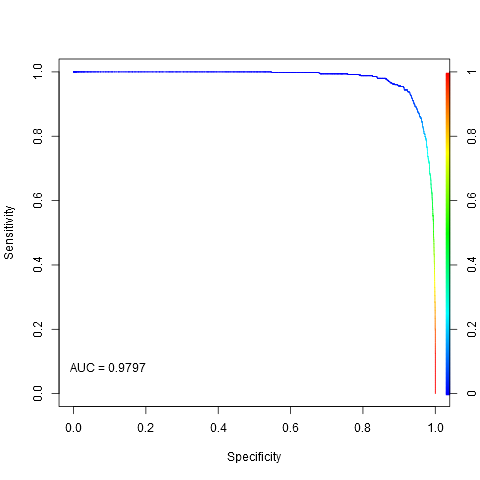

In [8]:
%%R

library(neuralnet)

# Use the tree library to predict probabilities
nnModelRep5Pred = compute(nnModelRep5, playerAggDfAllNbaAllStar[,c('advancedStats_WS_scaled', 'advancedStats_VORP_scaled')], rep = 1)

# There are "prediction" functions in both the neuralnet and ROCR package, we can't have both loaded in at the same time
detach(package:neuralnet,unload = T)
library(ROCR)

# Use the ROCR library to build the ROC curve
nnModelRep5PredObj = prediction(nnModelRep5Pred$net.result, ifelse(playerAggDfAllNbaAllStar['accolades_all_nba'] == 'All-NBA', TRUE, FALSE))

# Run performance evaluation for the metric 'total accuracy'
nnModelRep5RocEval = performance(nnModelRep5PredObj, 'sens', 'spec')
plot(nnModelRep5RocEval, colorize = T)
text(
    0.2, 
    0.08, 
    labels = paste("AUC = ", round(performance(nnModelRep5PredObj, 'auc')@y.values[[1]], digits = 4), sep= ""), 
    adj = 1
)

Pretty solid. I wonder if having more hidden layers would do any better?

In [9]:
%%R

library(neuralnet)

# Build neural net, repeating 5 times, storing 5 models
nnModel2Hidden = neuralnet(
    accolades_all_nba_coded ~ advancedStats_WS_scaled + advancedStats_VORP_scaled,
    data = playerAggDfAllNbaAllStar,
    hidden = c(2, 2),
    threshold = 0.05,
    err.fct = 'ce',
    lifesign = 'full',
    lifesign.step = 5000,
    linear.output = FALSE,
    rep = 5
)

Output:

hidden: 2, 2    thresh: 0.05    rep: 1/5    steps:    5000      min thresh: 0.3955336051
- 10000 min thresh: 0.3955336051
- 15000      min thresh: 0.3955336051
- 20000      min thresh: 0.2944346891
- 25000      min thresh: 0.1514456265
- 30000      min thresh: 0.1359256709
- 35000      min thresh: 0.09372016559
- 40000      min thresh: 0.05227332562
- 45000      min thresh: 0.05227332562
- 46863      error: 791.34253        

time: 5.12 mins

hidden: 2, 2    thresh: 0.05    rep: 2/5    steps:    5000      min thresh: 0.6179241594
- 10000      min thresh: 0.3148427128
- 15000      min thresh: 0.1755151267
- 20000      min thresh: 0.08121020021
- 25000      min thresh: 0.06796550208
- 30000      min thresh: 0.05359180631
- 31160      error: 791.3182

time: 3.6 mins

hidden: 2, 2    thresh: 0.05    rep: 3/5    steps:    5000      min thresh: 0.336480323
- 10000      min thresh: 0.194590099
- 15000      min thresh: 0.1081819564
- 20000      min thresh: 0.08069576852
- 20743      error: 791.37022

time: 2.37 mins

hidden: 2, 2    thresh: 0.05    rep: 4/5    steps:    5000      min thresh: 0.4791332965
- 10000      min thresh: 0.3788586331
- 15000      min thresh: 0.1683987977
- 20000      min thresh: 0.09008662785
- 25000      min thresh: 0.09008662785
- 30000      min thresh: 0.08226159099
- 35000      min thresh: 0.08039260278
- 40000      min thresh: 0.07640665468
- 45000      min thresh: 0.06796039954
- 50000      min thresh: 0.0613511424
- 54612      error: 791.35667

time: 6.31 mins

hidden: 2, 2    thresh: 0.05    rep: 5/5    steps:    5000      min thresh: 0.3201829626
- 10000      min thresh: 0.1041002266
- 15000      min thresh: 0.08308167395
- 20000      min thresh: 0.06539671163
- 25000      min thresh: 0.0535168671
- 28251      error: 791.34216

time: 3.31 mins

Here, we see that our model definitely took longer to train (and also quite inconsistent actually ranging from 3-6 mins), but the error remains about the same it was before... Let's check the AUC real quick of th ebest model (model \#2):

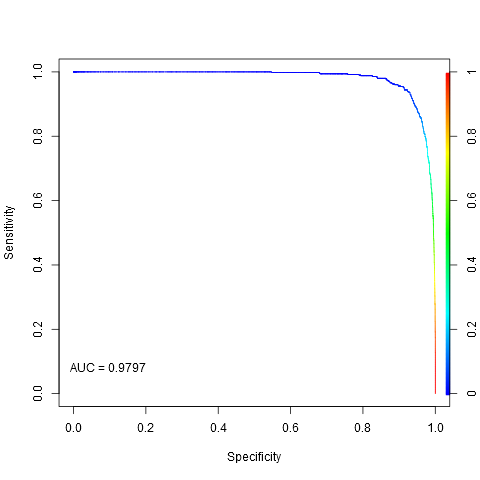

In [11]:
%%R

library(neuralnet)

# Use the tree library to predict probabilities
nnModel2HiddenPred = compute(nnModel2Hidden, playerAggDfAllNbaAllStar[,c('advancedStats_WS_scaled', 'advancedStats_VORP_scaled')], rep = 2)

# There are "prediction" functions in both the neuralnet and ROCR package, we can't have both loaded in at the same time
detach(package:neuralnet,unload = T)
library(ROCR)

# Use the ROCR library to build the ROC curve
nnModel2HiddenPredObj = prediction(nnModel2HiddenPred$net.result, ifelse(playerAggDfAllNbaAllStar['accolades_all_nba'] == 'All-NBA', TRUE, FALSE))

# Run performance evaluation for the metric 'total accuracy'
nnModel2HiddenRocEval = performance(nnModel2HiddenPredObj, 'sens', 'spec')
plot(nnModel2HiddenRocEval, colorize = T)
text(
    0.2, 
    0.08, 
    labels = paste("AUC = ", round(performance(nnModel2HiddenPredObj, 'auc')@y.values[[1]], digits = 4), sep= ""), 
    adj = 1
)

Same thing! Doesn't look like we need the complexity of 2 hidden nodes especially with the 6x training time. Probably even 1 hidden layer node is good!

In [12]:
%%R

library(neuralnet)

# Build neural net, repeating 5 times, storing 5 models
nnModel1Hidden = neuralnet(
    accolades_all_nba_coded ~ advancedStats_WS_scaled + advancedStats_VORP_scaled,
    data = playerAggDfAllNbaAllStar,
    hidden = 1,
    threshold = 0.05,
    err.fct = 'ce',
    lifesign = 'full',
    lifesign.step = 5000,
    linear.output = FALSE,
    rep = 5
)

I'll spare the entire output, but we're getting around 798 error, higher than before!

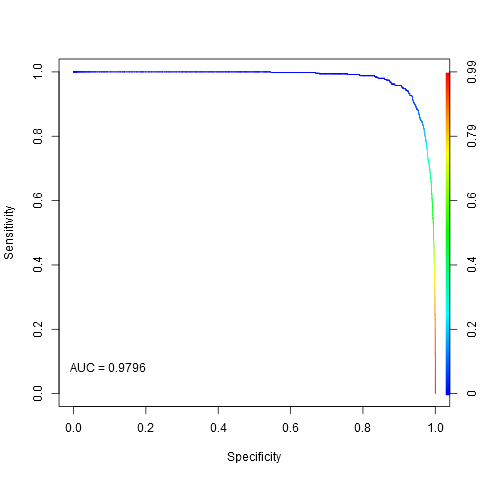

In [14]:
%%R

library(neuralnet)

# Use the tree library to predict probabilities
nnModel1HiddenPred = compute(nnModel1Hidden, playerAggDfAllNbaAllStar[,c('advancedStats_WS_scaled', 'advancedStats_VORP_scaled')], rep = 2)

# There are "prediction" functions in both the neuralnet and ROCR package, we can't have both loaded in at the same time
detach(package:neuralnet,unload = T)
library(ROCR)

# Use the ROCR library to build the ROC curve
nnModel1HiddenPredObj = prediction(nnModel1HiddenPred$net.result, ifelse(playerAggDfAllNbaAllStar['accolades_all_nba'] == 'All-NBA', TRUE, FALSE))

# Run performance evaluation for the metric 'total accuracy'
nnModel1HiddenRocEval = performance(nnModel1HiddenPredObj, 'sens', 'spec')
plot(nnModel1HiddenRocEval, colorize = T)
text(
    0.2, 
    0.08, 
    labels = paste("AUC = ", round(performance(nnModel1HiddenPredObj, 'auc')@y.values[[1]], digits = 4), sep= ""), 
    adj = 1
)

We lost about 0.0001 on our AUC, in other words, we really really don't care. I can see how people get deep into NN's now... just picking what's in the hidden layers is an interesting exercise in itself, and for something like image detection, I feel like we could spend... what... days on end just tweaking that one parameter.

I would try to perform CV, but I might have to wait overnight before I kick off that script... At the fastest we were running at around 1.5 mins per model to train. If we're performing let's say even 5 fold CV and turning the repetition off on the NN and trying 1-5 hidden layer nodes, we're still looking at $5\ nodes \times 5\ CV \times 1.5\ mins = 37.5\ minutes$.

Alright that's not HORRIBLE, but it is pretty annoying considering we can grow a tree in like 0.0000000000000001 seconds and get pretty much the same result lol.

I don't even think the neuralnet package has a built in cross validation tuning function like the svm package did. I'll just leave this for now, but again, great predictive accuracy.